<a href="https://colab.research.google.com/github/blortle-dev/data-science-lasa/blob/main/Unit%205/Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [28]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [29]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [30]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

<Axes: xlabel='FT%', ylabel='FG%'>

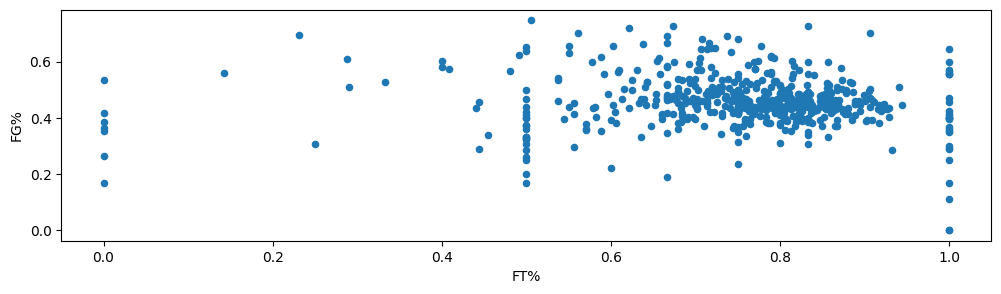

In [31]:
basketball.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

I notice that the data clumps up a lot between ~0.7 and ~0.9, and that there are vertical lines at 0.0, 0.5, and 1.0.

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

<Axes: xlabel='Pos', ylabel='FG%'>

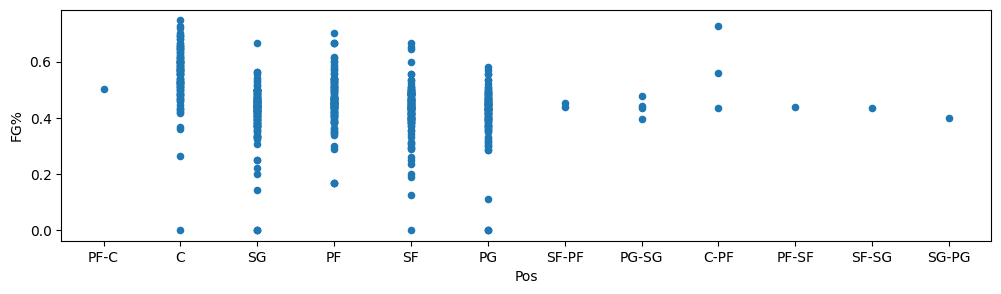

In [32]:
# Used this to see all possible positions, >> not a part of my answer!!! <<

basketball.plot(x="Pos", y="FG%", figsize=(12, 3), kind="scatter")

<Axes: xlabel='FT%', ylabel='FG%'>

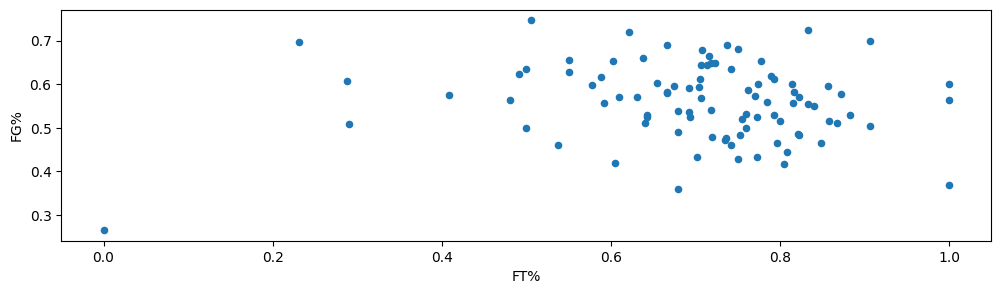

In [33]:
# POSITION: C
c_filtered = basketball[basketball['Pos'] == 'C']
c_filtered.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

<Axes: xlabel='FT%', ylabel='FG%'>

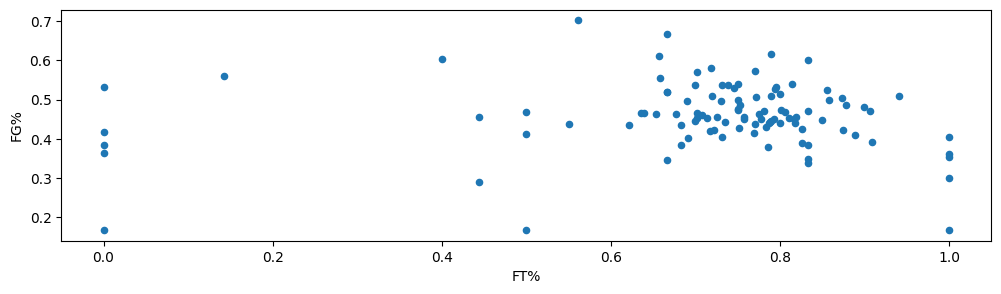

In [34]:
# POSITION: PF
pf_filtered = basketball[basketball['Pos'] == 'PF']
pf_filtered.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

<Axes: xlabel='FT%', ylabel='FG%'>

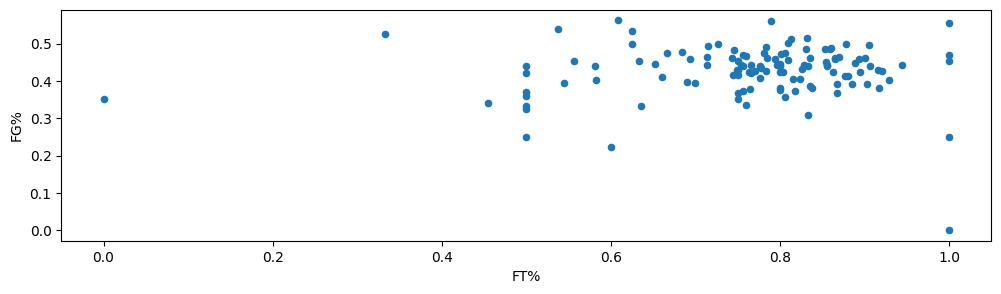

In [35]:
# POSITION: SG
sg_filtered = basketball[basketball['Pos'] == 'SG']
sg_filtered.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

<Axes: xlabel='FT%', ylabel='FG%'>

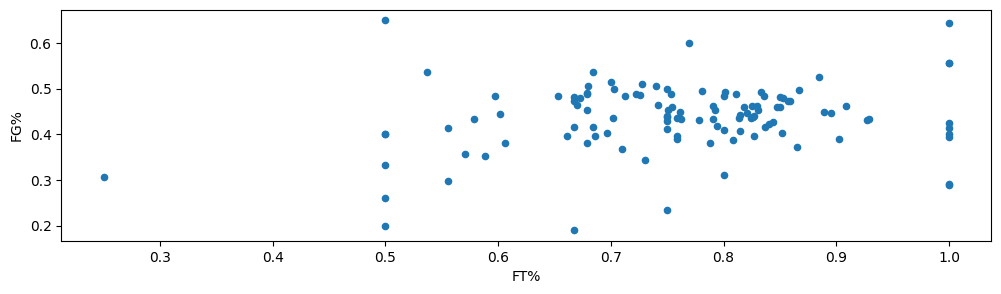

In [36]:
# POSITION: SF
sf_filtered = basketball[basketball['Pos'] == 'SF']
sf_filtered.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

<Axes: xlabel='FT%', ylabel='FG%'>

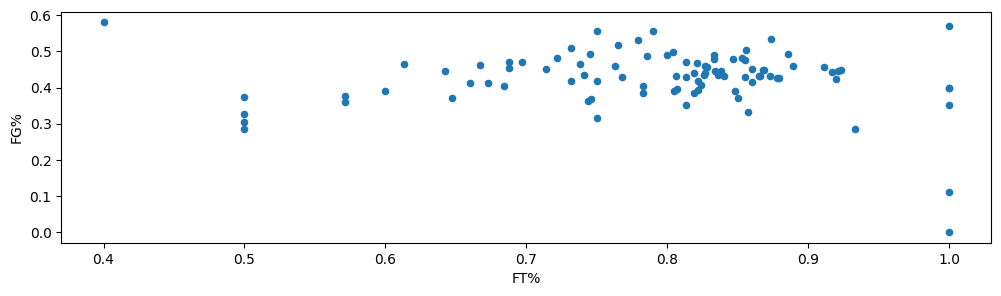

In [37]:
# POSITION: PG
pg_filtered = basketball[basketball['Pos'] == 'PG']
pg_filtered.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

<Axes: xlabel='FT%', ylabel='FG%'>

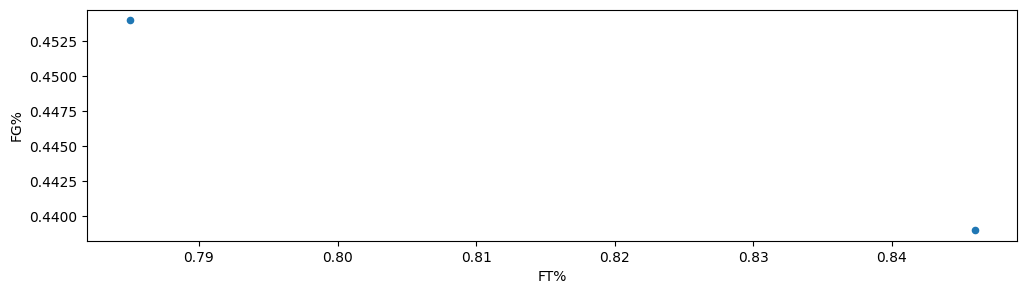

In [38]:
# POSITION: SF-PF
sfpf_filtered = basketball[basketball['Pos'] == 'SF-PF']
sfpf_filtered.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

<Axes: xlabel='FT%', ylabel='FG%'>

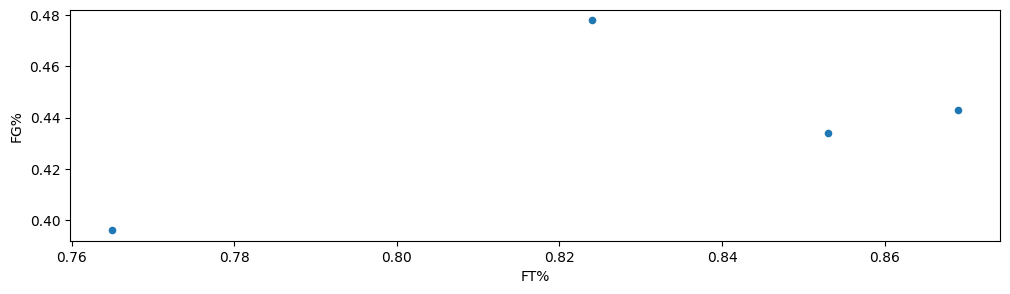

In [39]:
# POSITION: PG-SG
pgsg_filtered = basketball[basketball['Pos'] == 'PG-SG']
pgsg_filtered.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

<Axes: xlabel='FT%', ylabel='FG%'>

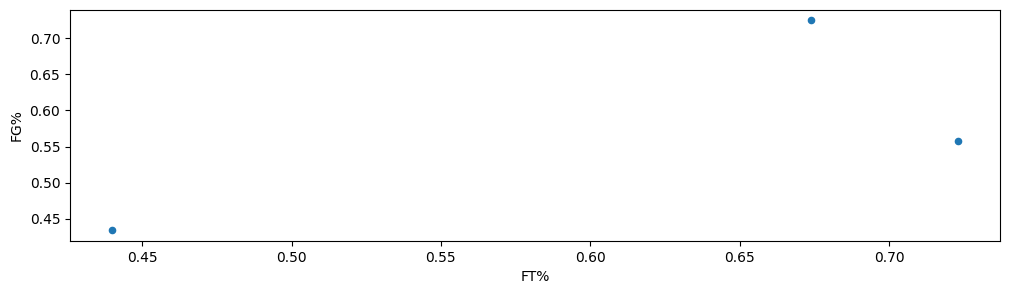

In [40]:
# POSITION: C-PF
cpf_filtered = basketball[basketball['Pos'] == 'C-PF']
cpf_filtered.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

<Axes: xlabel='FT%', ylabel='FG%'>

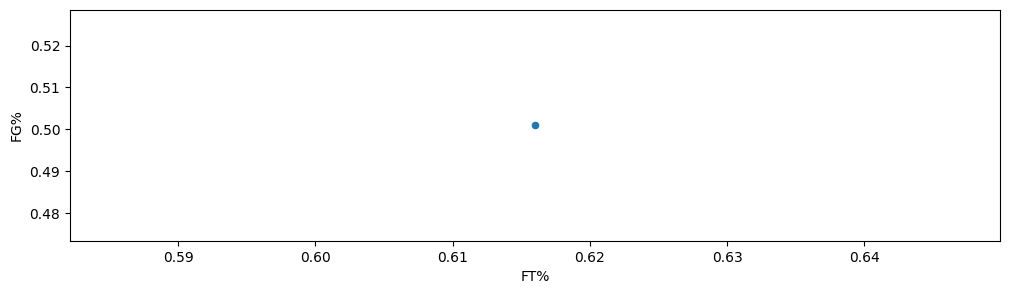

In [41]:
# POSITION: PF-C
pfc_filtered = basketball[basketball['Pos'] == 'PF-C']
pfc_filtered.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

<Axes: xlabel='FT%', ylabel='FG%'>

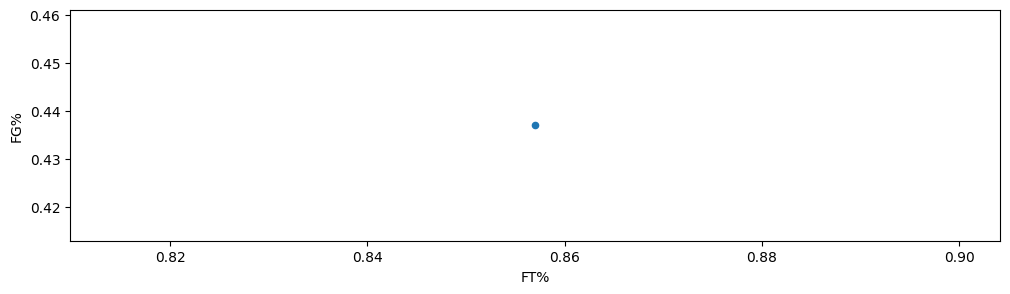

In [42]:
# POSITION: PF-SF
pfsf_filtered = basketball[basketball['Pos'] == 'PF-SF']
pfsf_filtered.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

<Axes: xlabel='FT%', ylabel='FG%'>

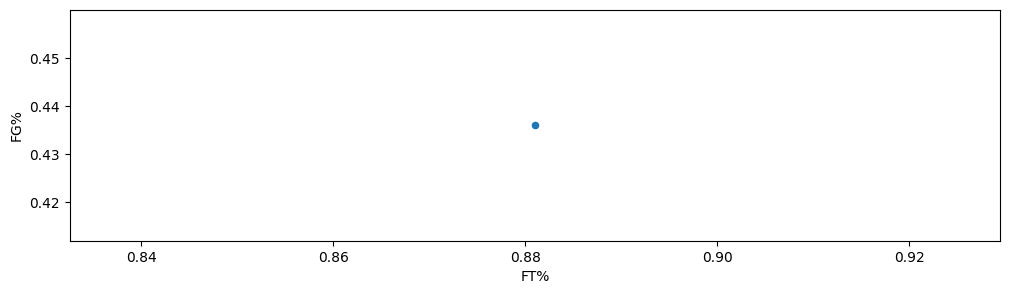

In [43]:
# POSITION: SF-SG
sfsg_filtered = basketball[basketball['Pos'] == 'SF-SG']
sfsg_filtered.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

<Axes: xlabel='FT%', ylabel='FG%'>

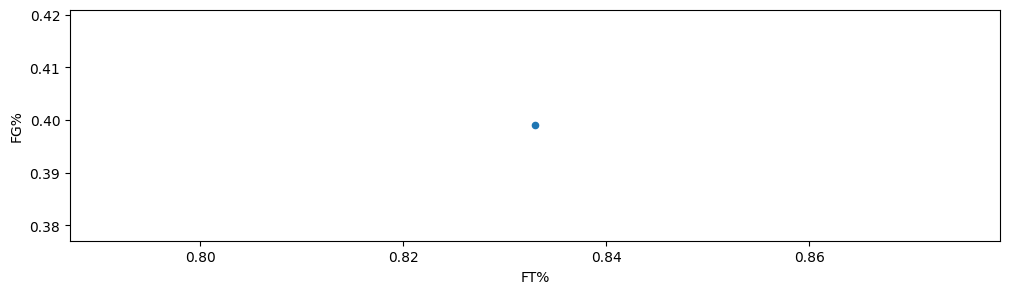

In [44]:
# POSITION: SG-PG
sgpg_filtered = basketball[basketball['Pos'] == 'SG-PG']
sgpg_filtered.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

In [58]:
# My (unsuccessful) attempts to create a model are below

with pm.Model() as model_test:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * basketball["FT%"])

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=basketball["FG%"])

    idata_test = pm.sample()

/usr/local/lib/python3.10/dist-packages/pymc/model/core.py:1278: ImputationWarning: Data in y_pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'α': array(0.0794407), 'β': array(-0.67091153), 'σ_log__': array(2.67125317), 'y_pred_unobserved': array([nan, nan, nan, nan])}

Logp initial evaluation results:
{'α': -3.22, 'β': -3.22, 'σ': -0.9, 'y_pred_unobserved': nan, 'y_pred_observed': nan}
You can call `model.debug()` for more details.

Above, I tried to create my own model using the sample code from the Unit 5 Notes Answer Key. We can see the model had a SamplingError, returning `Initial evaluation of model at starting point failed!` My best guess as to why this didn't work is because of the nature of our dataset. I'll put another look at the scatter plot from Task 1 below:

<Axes: xlabel='FT%', ylabel='FG%'>

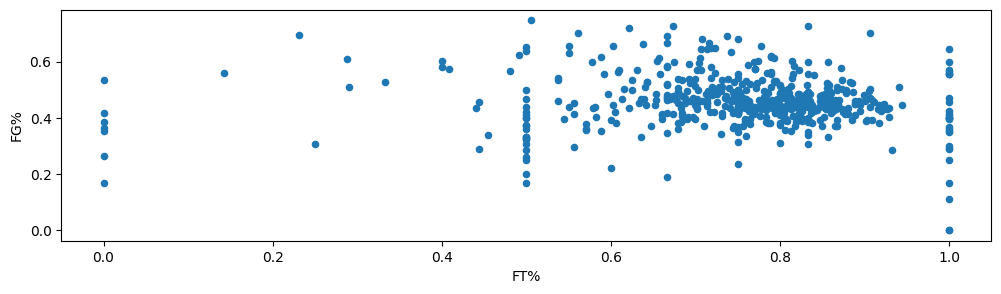

In [59]:
basketball.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

As we can see, the dataset tends to have a cloud between ~0.6 and ~0.95. Additionally, the dataset has vertical lines of data at ~0.0, ~0.5, and ~1.0. My best guess as to why this didn't work is because there is no line able to fit that abstract and "random" (by that I mean not in any sort of pattern) of a dataset.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [45]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [46]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

<Axes: xlabel='weight', ylabel='height'>

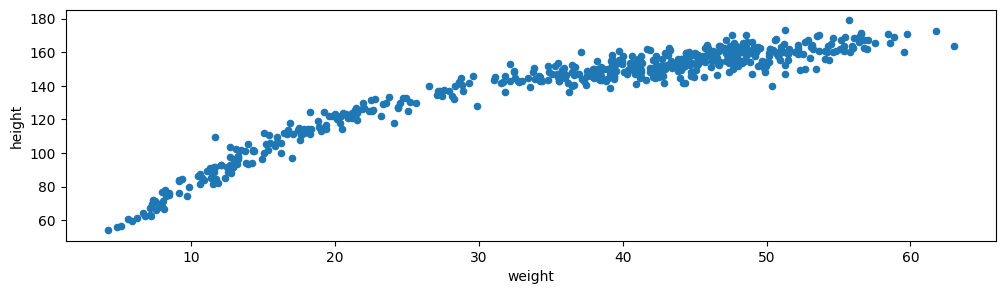

In [47]:
howell.plot(x="weight",y="height",figsize=(12,3),kind="scatter")

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [48]:
with pm.Model() as model_exc:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * howell.weight)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.height)

    idata_exc = pm.sample()

Output()

Output()

Text(0.5, 0, 'weight')

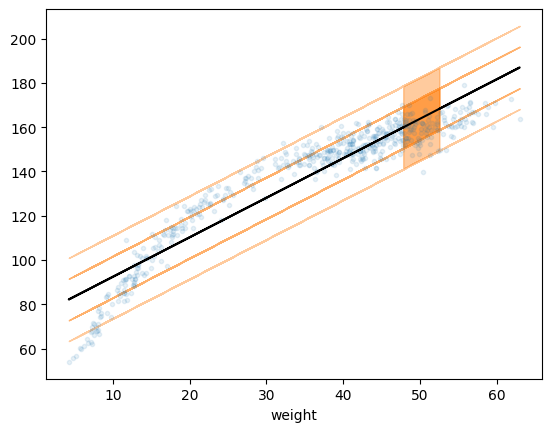

In [49]:
#plots the posterior

_, ax = plt.subplots()

ax.plot(howell.weight, howell.height, "C0.", alpha=0.1)

posterior_exc = az.extract(idata_exc)

μ_m = posterior_exc["μ"].mean("sample").values
σ_m = posterior_exc["σ"].mean("sample").values

ax.plot(howell.weight, μ_m, c="k")
ax.fill_between(howell.weight, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(howell.weight, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("weight")

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

In [50]:
pm.sample_posterior_predictive(
    idata_exc, model = model_exc, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

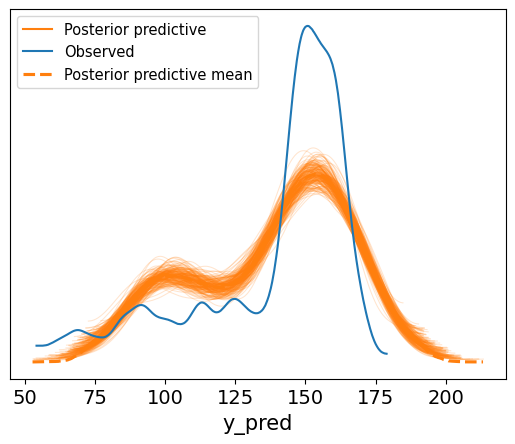

In [51]:
az.plot_ppc(idata_exc, num_pp_samples=200, colors=["C1", "C0", "C1"])

The fit is pretty bad overall. Especially between 150 and 175 on the X axis, we can see the observed data is wildly different from our posterior predictive.

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

<Axes: xlabel='weight', ylabel='height'>

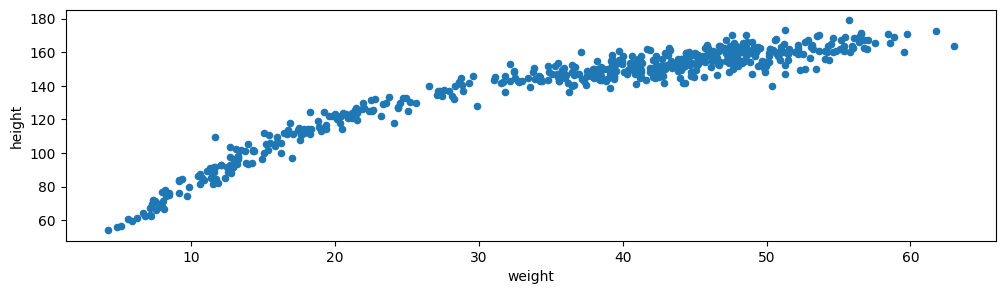

In [52]:
# Getting another look at that scatter plot

howell.plot(x="weight",y="height",figsize=(12,3),kind="scatter")

In [53]:
# Stolen from Unit 5 Notes AK

with pm.Model() as model_sqrthow:

    #priors for our mean line
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * pm.math.sqrt(howell.weight))

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.height)

    idata_sqrthow = pm.sample()

Output()

Output()

Text(0, 0.5, 'height')

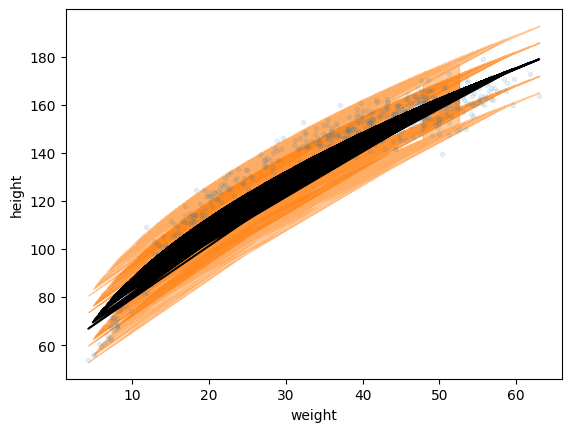

In [54]:
# Also stolen from Unit 5 Notes AK

#plots the posterior

_, ax = plt.subplots()

ax.plot(howell.weight, howell.height, "C0.", alpha=0.1)

posterior_sqrthow = az.extract(idata_sqrthow)

μ_m = posterior_sqrthow["μ"].mean("sample").values
σ_m = posterior_sqrthow["σ"].mean("sample").values

ax.plot(howell.weight, μ_m, c="k")
ax.fill_between(howell.weight, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(howell.weight, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("weight")
ax.set_ylabel("height")

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

Output()

<Axes: xlabel='y_pred'>

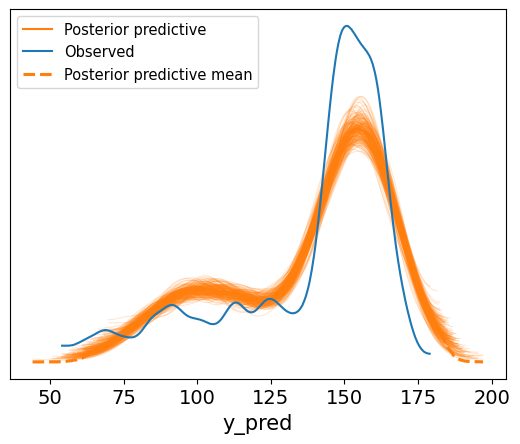

In [57]:
#creates our posterior predictive distribution
pm.sample_posterior_predictive(
    idata_sqrthow, model = model_sqrthow, extend_inferencedata=True
    )

# posterior predictive check
az.plot_ppc(idata_sqrthow, num_pp_samples=200, colors=["C1", "C0", "C1"])

This model fits a lot better than our previous model. The primary issue with our initial model was it didn't match the observed data between 150 and 175 on the X axis. While this model isn't perfect and doesn't match either, it most definitely is a lot closer and more accurate to our dataset.